# Generate examples from chapter 2 
Reproduce figures from chapter 2 in "Gaussian Processes for Machine learning". 


## Reproduce figure 2.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#generate x vector
x = np.arange(-5,5, step=0.2)

In [3]:
#define function for finding the gaussian kernel
#xstar is a datapoint, x is an array
def SquaredExponential(x, xstar, sigmaf, l):
    #equation 2.31
    k = sigmaf**2*np.exp(-1/(2*l**2)*(x-xstar)**2)
    return k 

In [4]:
Kprior = np.zeros((len(x), len(x)))

for i in range(len(x)):
    Kprior[i,:] = SquaredExponential(x, x[i],1,1)

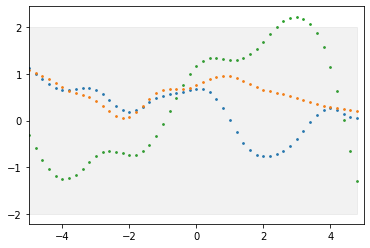

In [5]:
# generate samples from prior and plot
samples = np.random.multivariate_normal(np.zeros(len(x)), Kprior, 3)
upperbound = np.repeat(2, len(x))
lowerbound = np.repeat(-2, len(x))

for i in range(3):
    plt.scatter(x, samples[i,:], s= 3)

plt.xlim(-5,5)
plt.fill_between(x, upperbound, lowerbound, alpha=0.1, color = 'gray')
plt.show()

In [6]:
#generate posterior
fobs = np.array([-2, 0, 1, 2, -1])
xobs = np.array([-4, -2, 0, 2, 4])

K = np.zeros((len(xobs), len(xobs)))
Kstarx = np.zeros((len(xobs), len(x)))
for i in range(len(xobs)):
    K[i,:] = SquaredExponential(xobs, xobs[i],1,1)
    Kstarx[i,:] = SquaredExponential(x, xobs[i],1,1)

postmean = np.matmul(np.matmul(np.transpose(Kstarx), np.linalg.inv(K)), fobs)
postcov = Kprior - np.matmul(np.matmul(np.transpose(Kstarx), np.linalg.inv(K)), Kstarx)

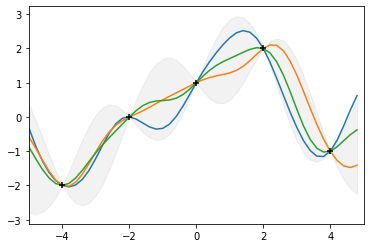

In [7]:
# generate samples from poster and plot
samples = np.random.multivariate_normal(postmean, postcov, 3)
upperbound = postmean + 2*np.sqrt(abs(np.diagonal(postcov)))
lowerbound = postmean - 2*np.sqrt(abs(np.diagonal(postcov)))

for i in range(3):
    plt.plot(x, samples[i,:])

plt.xlim(-5,5)
plt.fill_between(x, upperbound, lowerbound, alpha=0.1, color = 'gray')
ax = plt.gca()
ax.scatter(xobs, fobs, marker = '+', color = 'black', zorder=3)
plt.show()

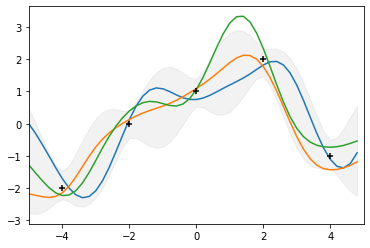

In [8]:
## case with noise
sigma = 0.05
postmean = np.matmul(np.matmul(np.transpose(Kstarx), np.linalg.inv(K+sigma*np.identity(len(xobs)))), fobs)
postcov = Kprior - np.matmul(np.matmul(np.transpose(Kstarx), np.linalg.inv(K+sigma*np.identity(len(xobs)))), Kstarx)

# generate samples from posterior and plot
samples = np.random.multivariate_normal(postmean, postcov, 3)
upperbound = postmean + 2*np.sqrt(abs(np.diagonal(postcov)))
lowerbound = postmean - 2*np.sqrt(abs(np.diagonal(postcov)))

for i in range(3):
    plt.plot(x, samples[i,:])

plt.xlim(-5,5)
plt.fill_between(x, upperbound, lowerbound, alpha=0.1, color = 'gray')
ax = plt.gca()
ax.scatter(xobs, fobs, marker = '+', color = 'black', zorder=3)
plt.show()

## Reproduce figure 2.5

In [9]:
#Implement algorithm 2.1 from book
def algorithm21(X, y, K, xstar, sigma, sigmaf, l):
    L = np.linalg.cholesky(K + sigma*np.identity(K.shape[1]))
    a = np.linalg.solve(np.transpose(L), np.linalg.solve(L, y))
    
    if isinstance(xstar, list) or isinstance(xstar, np.ndarray): #if multiple test points are given
        fstar = np.zeros(len(xstar))
        Vstar = np.zeros(len(xstar))
        for i in range(len(xstar)):
            kstar = SquaredExponential(X, xstar[i], sigmaf, l)
            fstar[i] = np.matmul(np.transpose(kstar),a)
            v = np.linalg.solve(L, kstar)
            kstarstar = SquaredExponential(xstar[i], xstar[i], sigmaf, l)
            Vstar[i] = kstarstar - np.matmul(np.transpose(v),v)
    else: #if only one test point is given
        kstar = SquaredExponential(X, xstar, sigmaf, l)
        v = np.linalg.solve(L, kstar)
        fstar = np.matmul(np.transpose(kstar),a)
        v = np.linalg.solve(L, kstar)
        kstarstar = SquaredExponential(xstar[i], xstar, sigmaf, l)
        Vstar = kstarstar - np.matmul(np.transpose(v),v)
    
    loglik = -1/2*np.matmul(np.transpose(y),a)- np.sum(np.log(np.diagonal(L))) - len(y)/2*np.log(np.pi*2)
    
    return fstar, Vstar, loglik

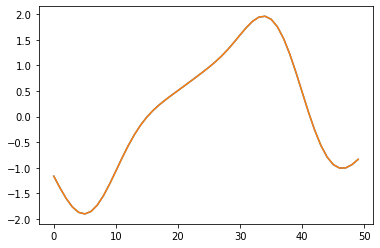

In [10]:
#check that algorithm produces the same as equations above
fstar, Vstar, loglik = algorithm21(xobs, fobs, K, np.transpose(x),sigma, sigmaf=1, l=1)
plt.plot(fstar)
plt.plot(postmean)
plt.show()

In [11]:
#generate observed data by generating X from a uniform distribution and Y from a GP with covariance given by the
#squared exponential kernel with sigma_f=1, l=1 plus observation noise sigma_n=0.1 
xobs = np.random.uniform(-5, 5, 20)
K = np.zeros((len(xobs), len(xobs)))
sigman = 0.1
for i in range(len(xobs)):
    K[i,:] = SquaredExponential(xobs, xobs[i], 1, 1)

yobs = np.random.multivariate_normal(np.zeros(len(xobs)), K + sigman*np.identity(len(xobs)))

In [12]:
#fit models
xstar = np.arange(-5,5, step=0.1)
fstar = np.zeros((3,len(xstar)))
Vstar = np.zeros((3, len(xstar)))
loglik = np.zeros(3)
params = [(0.1,1,1), (0.00005, 1.08, 0.3), (0.89, 1.16, 3)] #from figure 2.5 in the book

for i in range(3):
    K = np.zeros((len(xobs), len(xobs)))
    p=params[i]
    for j in range(len(xobs)):
        K[j,:] = SquaredExponential(xobs, xobs[j], p[1], p[2])
    fstar[i,:], Vstar[i,:], loglik[i] = algorithm21(xobs, yobs, K, xstar, sigma = p[0], sigmaf=p[1], l=p[2])

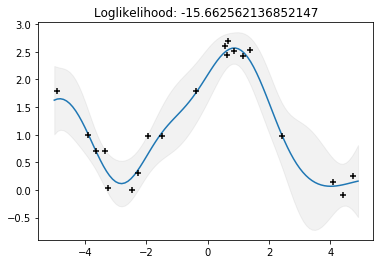

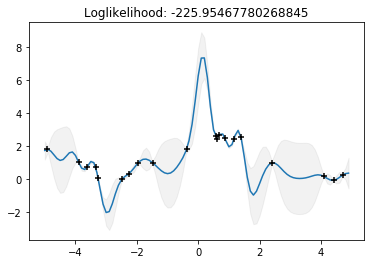

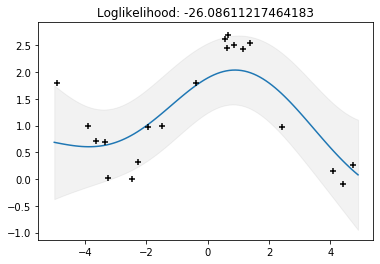

In [13]:
#plot the different fits
for i in range(3):
    plt.plot(xstar, fstar[i,:])
    upper = fstar[i,:]+2*np.sqrt(abs(Vstar[i,:]))
    lower = fstar[i,:]-2*np.sqrt(abs(Vstar[i,:]))
    plt.fill_between(xstar, upper, lower, alpha=0.1, color = 'gray')
    plt.scatter(xobs, yobs, marker= '+', zorder = 3, color = 'black')
    plt.title('Loglikelihood: ' + str(loglik[i]))
    plt.show()

## Experiment with equation 2.36

In [115]:
xobs1 = np.random.uniform(-5, -4, (5,2))
xobs2 = np.random.uniform(4, 5, (1,2))
xobs = np.append(xobs1, xobs2, axis = 0)
K = np.zeros((len(xobs), len(xobs)))
sigman = 0.1
sigmaf = 1
l = 1

for i in range(len(xobs)):
    for j in range(len(xobs)):
        K[i,j] = sigmaf**2*np.exp(-1/(2*l**2)*(np.linalg.norm(xobs[j,:]-xobs[i,:]))**2)

yobs = np.random.multivariate_normal(np.zeros(len(xobs)), K + sigman*np.identity(len(xobs)))

In [116]:
#find eigenvalues of K 
lamb, u = np.linalg.eig(K)

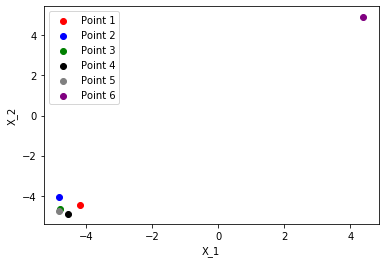

In [128]:
colors = ['red', 'blue', 'green', 'black', 'grey', 'purple']
origin = np.array([[0, 0, 0],[0, 0, 0]])

for i in range(len(xobs)):
    plt.scatter(xobs[i,0], xobs[i,1], c=colors[i], label = 'Point ' + str(i+1))
    #plt.quiver(*origin, u[i,0]*lamb[i], u[i,1]*lamb[i])
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.legend()
plt.show()

In [130]:
#compute gamma and the constant from equation 2.36
gamma = np.matmul(np.transpose(u), yobs)
const = lamb/(lamb+sigman)
sortidx = np.argsort(lamb/(lamb+sigman))

#find smallest and largest constant and the corresponding eigenvectors
u_small = u[np.argmin(const),:]
u_large = u[np.argmax(const),:]

for i in range(len(const)):
    print('Constant:', const[i])
    print('Gamma:', gamma[i])
    print('Corresponding eigenvector:\n', u[i,:], '\n')

Constant: 0.9777294559924908
Gamma: 0.5914853542212206
Corresponding eigenvector:
 [ 4.28928376e-01  8.63236229e-01  3.33697397e-02  2.58181521e-01
 -5.54294422e-02  6.37928574e-36] 

Constant: 0.7192171256520177
Gamma: -0.5778194364575877
Corresponding eigenvector:
 [ 4.14861556e-01 -7.94435865e-02 -8.45014800e-01 -3.24509460e-01
 -4.71402578e-02 -8.12919618e-37] 

Constant: 0.7715402739388157
Gamma: -0.8887770507502739
Corresponding eigenvector:
 [ 4.70391940e-01 -3.08669721e-01  6.72581928e-02  3.96894301e-01
  7.22084258e-01 -2.49102084e-36] 

Constant: 0.134315575139335
Gamma: 0.3170054969770566
Corresponding eigenvector:
 [ 4.54236220e-01 -2.28083009e-02  5.03739277e-01 -7.32720638e-01
  5.01641788e-02 -2.01328257e-36] 

Constant: 0.003859121652889175
Gamma: -0.23897484821636375
Corresponding eigenvector:
 [ 4.65092697e-01 -3.90787300e-01  1.62970931e-01  3.65556141e-01
 -6.86136468e-01 -2.65241930e-36] 

Constant: 0.9090909090909091
Gamma: -0.45356548761754945
Corresponding eige

In [132]:
#generate new point in the middle and consider weighting
xstar = [0,0]
Kstar = np.zeros(len(xobs))
for j in range(len(xobs)):
    K[j] = sigmaf**2*np.exp(-1/(2*l**2)*(np.linalg.norm(xobs[j,:]-xobs[i,:]))**2)